<a href="https://colab.research.google.com/github/pardalin/age_group_from_chat/blob/main/age_group_from_chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a just for fun -project I did on my spare time. I decided to see if it would be possible to determine the age group of a person from their messages in this chat corpus.

In the corpus, the chatters are assigned to a group based on their age, so basically this can be seen as a classification problem.

From the corpus' readme file:
"GROUP : Participant's background: University staff = 1, university student = 2, high schooler = 3"

In the following, this is changed so that each group number is the number above - 1 (so that indexing starts at 0, Python isn't happy otherwise)

In [31]:
!pip3 install -q transformers datasets seqeval

In [32]:
import pandas as pd
import transformers
import datasets
import logging
from collections import defaultdict
import torch
logging.disable(logging.INFO)

In [33]:
!wget -nc -q https://korp.csc.fi/download/finchat/finchat-src/finchat-src.zip
!unzip finchat-src.zip

# citation of this corpus:
# Leino, K., Leinonen, J., Singh, M., Virpioja, S., & Kurimo, M.. Finnish conversational chat corpus, source [text corpus].
# Kielipankki. Retrieved from http://urn.fi/urn:nbn:fi:lb-2022060801

Archive:  finchat-src.zip
replace finchat-src/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: finchat-src/LICENSE.txt  
  inflating: finchat-src/README.txt  
  inflating: finchat-src/data/finchat_meta_data.csv  
  inflating: finchat-src/data/finchat_chat_conversations.csv  


In [34]:
chat_data = pd.read_csv("finchat-src/data/finchat_chat_conversations.csv")
meta_data = pd.read_csv("finchat-src/data/finchat_meta_data.csv")
chat_data.head() #chat texts don't have the relevant group

,CHAT_ID,SPEAKER_ID,TIME,TEXT
0,4,3,11:10:22.187,Moi
1,4,7,11:10:27.521,Tere!
2,4,3,11:10:46.830,Ootko nähnyt jotain hyviä leffoja viimeaikoina?
3,4,7,11:11:48.573,"Viimeksi taisin käydä keväällä, kun piti kulut..."
4,4,3,11:12:31.667,"Hmm en oo kai kuullukaan tosta, millane leffa ..."


In [35]:
meta_data.head()

,CHAT_ID,SPEAKER_ID,GROUP,TOPIC,OFFTOPIC,Q1,Q2,Q3,Q4,Q5
0,7,0,1,movies,0,2,1,1,0,0
1,10,0,1,sports,0,2,1,1,0,0
2,6,1,1,movies,0,2,1,1,0,0
3,15,1,1,sports,0,2,1,1,0,0
4,7,5,1,movies,0,2,1,1,0,0


In [36]:
meta_data.drop(columns=["CHAT_ID", "TOPIC", "OFFTOPIC", "Q1", "Q2", "Q3", "Q4", "Q5"], inplace=True)
meta_data.drop_duplicates()

,SPEAKER_ID,GROUP
0,0,1
2,1,1
4,5,1
6,2,1
8,3,1
...,...,...
148,92,2
149,91,2
150,93,2
151,90,2


In [37]:
new_data = pd.merge(meta_data, chat_data, on="SPEAKER_ID")
new_data.head()

,SPEAKER_ID,GROUP,CHAT_ID,TIME,TEXT
0,0,1,7,11:11:13.477,Kuuleeko kukaan?
1,0,1,7,11:13:21.867,Mikä leffan katsoit viimeksi?
2,0,1,7,11:14:51.907,Itselläni taisi olla Downton abbey
3,0,1,7,11:15:40.162,Ehkä joku 8
4,0,1,10,11:21:01.204,Seuraatko jotain urheilua?


In [38]:
new_data.drop(columns=["SPEAKER_ID", "CHAT_ID", "TIME"], inplace=True)
new_data["GROUP"] = new_data["GROUP"]-1

In [39]:
new_data # now I have a df with only the texts and the relevant group number

,GROUP,TEXT
0,0,Kuuleeko kukaan?
1,0,Mikä leffan katsoit viimeksi?
2,0,Itselläni taisi olla Downton abbey
3,0,Ehkä joku 8
4,0,Seuraatko jotain urheilua?
...,...,...
10192,1,Heips! Tässähän tämä. Harvemmin tulee reissatt...
10193,1,Oi vähänkö toi on kiva tapa! Tykkään tosta aja...
10194,1,Öää mitäköhän mä nyt sanoisin. Ehkä kun oltiin...
10195,1,Eikä siis siinä monessa paikassakaan käymisess...


In [40]:
label_names = [0,1,2]
new_data = new_data.rename(columns={"GROUP": "label", "TEXT": "text"})

In [41]:
dataset = datasets.Dataset.from_pandas(new_data, preserve_index=False, features=datasets.Features({"label":datasets.ClassLabel(names=label_names), "text":datasets.Value("string")}))

In [42]:
dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 10197
})

In [43]:
shuffled_data = dataset.shuffle(seed=130822)
shuffled_data = shuffled_data.train_test_split(test_size=0.1)

In [44]:
shuffled_data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 9177
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1020
    })
})

In [45]:
model_name = "TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, problem_type="multi_label_classification", padding='max_length', truncation=True, max_length=512)

In [46]:
def tokenize(example):
  return tokenizer(example["text"], max_length=512, truncation=True)

In [47]:
shuffled_data = shuffled_data.map(tokenize)

  0%|          | 0/9177 [00:00<?, ?ex/s]

  0%|          | 0/1020 [00:00<?, ?ex/s]

In [48]:
shuffled_data["train"][0]

{'label': 2,
 'text': 'miks',
 'input_ids': [102, 5792, 103],
 'token_type_ids': [0, 0, 0],
 'attention_mask': [1, 1, 1]}

In [49]:
id2label = {0: "Uni staff", 1: "uni student", 2: "high school"}

In [50]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names), id2label=id2label)
#problem_type="multi_label_classification"

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [51]:
class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [60]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1e-4,
    weight_decay=0.005,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    max_steps=1000,
)

In [61]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=shuffled_data["train"],
    eval_dataset=shuffled_data["test"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,0.403400,0.712302,0.849020
200,0.356800,0.534372,0.850000
300,0.365300,0.474613,0.878431
400,0.459100,0.522025,0.854902
500,0.451400,0.460936,0.860784
600,0.383900,0.486284,0.873529
700,0.324600,0.418349,0.894118
800,0.328400,0.414298,0.895098
900,0.302400,0.319245,0.916667
1000,0.277300,0.269661,0.930392


TrainOutput(global_step=1000, training_loss=0.3652502536773682, metrics={'train_runtime': 133.8858, 'train_samples_per_second': 59.752, 'train_steps_per_second': 7.469, 'total_flos': 108176615010576.0, 'train_loss': 0.3652502536773682, 'epoch': 0.87})

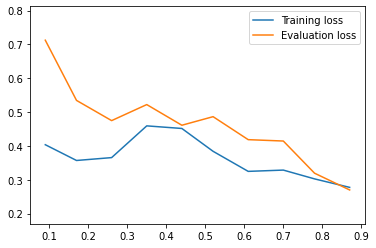

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

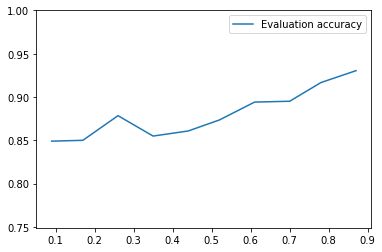

In [63]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])